In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

In [14]:
# Load Diabetes datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

In [15]:
X.shape, y.shape

((442, 10), (442,))

In [17]:
# Create pandas DataFrame for sklearn ElasticNet linear_model
Y = np.array([y]).transpose() # (1, 442) -> (442, 1)
d = np.concatenate((X, Y), axis=1)

In [21]:
d.shape

(442, 11)

In [22]:
cols = diabetes.feature_names + ["progression"]
cols

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']

In [23]:
data = pd.DataFrame(d, columns=cols)
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [24]:
# Evaluate metrics
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [25]:
warnings.filterwarnings("ignore")
np.random.seed(40)

In [26]:
# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)
train.shape, test.shape

((331, 11), (111, 11))

In [27]:
# The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
train_x = train.drop(["progression"], axis=1)
test_x = test.drop(["progression"], axis=1)
train_y = train[["progression"]]
test_y = test[["progression"]]

In [29]:
# alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.05
# l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.05
alpha = 0.05
l1_ratio = 0.05

In [30]:
# Run ElasticNet
lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
lr.fit(train_x, train_y)
predicted_qualities = lr.predict(test_x)
(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

In [31]:
# Print out ElasticNet model metrics
print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

Elasticnet model (alpha=0.050000, l1_ratio=0.050000):
  RMSE: 78.59248628523486
  MAE: 66.30996047256438
  R2: 0.06607454600721252


In [32]:
# Compute paths
eps = 5e-3 # the smaller it is the longer is the path

print("Computing regularization path using the elastic net.")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio)

Computing regularization path using the elastic net.


(-1.7481245827261356,
 0.7830084125042438,
 -7.616704299469891,
 11.011946248605973)

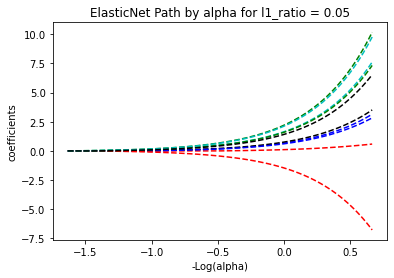

In [33]:
# Display results
fig = plt.figure(1)
ax = plt.gca()

colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
title = "ElasticNet Path by alpha for l1_ratio = " + str(l1_ratio)
plt.title(title)
plt.axis("tight")